In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

import d2l
# libraries needed
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torch.optim as optim
import matplotlib.pyplot as plt

Mounted at /content/gdrive


# 1. Implement an LSTM model for time series prediction (as in Section 9.1) rather than character sequence prediction

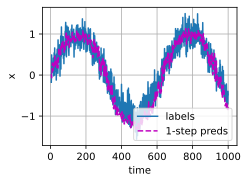

In [2]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

    def get_dataloader(self, train):
      features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
      self.features = torch.stack(features, 1)
      self.labels = self.x[self.tau:].reshape((-1, 1))
      i = slice(0, self.num_train) if train else slice(self.num_train, None)
      return self.get_tensorloader([self.features, self.labels], train, i)


    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

class TrainingWrapper(d2l.LinearRegression):
    def init_params(self):
        self.linear = nn.LazyLinear(1)

    def __init__(self, rnn,lr=0.01, tau=4, plot_flag=True, emb_len=8):
        super().__init__(lr=lr)
        self.save_hyperparameters()
        self.init_params()

    def forward(self, X, state=None):
        rnn_outputs, _ = self.rnn(X, state)
        return self.linear(rnn_outputs) # utilize the linear to improve

tau = 4 # number of inputs, connevention from book Tauth order markov condition
data = Data(tau=tau)
lstm = LSTM(num_inputs=tau, num_hiddens=8)
model = TrainingWrapper(rnn=lstm, lr=0.01)
trainer = d2l.Trainer(max_epochs=25)
trainer.fit(model, data)

onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

# 2. In the Deep RNN implementation in Section 10.3, implement an LSTM rather than GRU and compare the two approaches.

RNNLM(
  (rnn): GRU(
    (rnn): GRU(28, 32)
  )
  (linear): Linear(in_features=32, out_features=28, bias=True)
)


'it has heardite and why co'

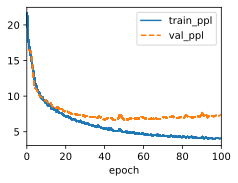

In [14]:
# GRU Implementation
seed = 64
torch.manual_seed(seed)

class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)

trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

print(model)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

RNNLM(
  (rnn): LSTM(
    (rnn): LSTM(28, 32, num_layers=2)
  )
  (linear): Linear(in_features=32, out_features=28, bias=True)
)


'it has in the the the the '

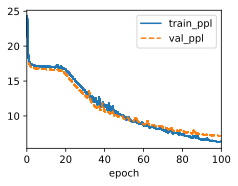

In [15]:
# LSTM Implementation
seed = 64
torch.manual_seed(seed)

class LSTM(d2l.RNN):
  'Multilayer LSTM'
  def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0): # similar to 10.3.2 expanding the concise implementation to include layers and changing the layers to be consitute of LSTM instead of grui
      d2l.Module.__init__(self)
      self.save_hyperparameters()
      self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers,
                        dropout=dropout)

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=2)

trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

print(model)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

# It can be seen that while the perpleixity of the GRU is slightly higher and the sentence makes more sense than the LSTM. This may be due to overfitting.

# 3. Extend the implementation of Section 10.4 to design a bidirectional RNN with multiple hidden layers.

RNNLM(
  (rnn): BiRNN(
    (rnn): RNN(28, 32, bidirectional=True)
  )
  (linear): Linear(in_features=64, out_features=28, bias=True)
)


'it hasasasasasasasasasasas'

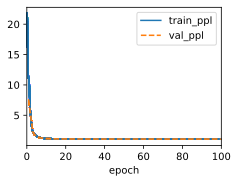

In [16]:
# BiGRU
seed = 64
torch.manual_seed(seed)

class BiRNN(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
BiRNN = BiRNN(num_inputs =len(data.vocab),num_hiddens=32)
model = d2l.RNNLM(BiRNN, vocab_size=len(data.vocab), lr=2)

trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

print(model)
model.predict('it has', 20, data.vocab, d2l.try_gpu())